## TF-IDF

The formula for calculating the TF-IDF (Term Frequency-Inverse Document Frequency) weight of a term in a document within a collection of documents is as follows:

$$TF-IDF = TF * IDF$$

where:
- TF (Term Frequency) measures the frequency of a term in a document and is calculated as the number of times the term appears in the document divided by the total number of terms in the document.
   $$TF = \lgroup\frac {\text{Number of occurrences of the term in the document}}  {\text{Total number of terms in the document }}\rgroup$$

- IDF (Inverse Document Frequency) measures the importance of a term in the entire collection of documents and is calculated as the logarithm of the total number of documents divided by the number of documents containing the term, with the result being inverted.
   $$IDF = log\lgroup\frac{\text{Total number of documents}} {\text{Number of documents containing the term}}\rgroup$$

The TF-IDF value represents the relevance of a term within a document and across the collection of documents. Higher TF-IDF values indicate that a term is more important to a particular document or collection.

<center><img src = "markdown_files/tf_idf.png"></center>

[Reference Link](https://medium.com/voice-tech-podcast/automatic-extractive-text-summarization-using-tfidf-3fc9a7b26f5#:~:text=tf%20is%20calculated%20as%20the,of%20words%20in%20the%20sentence.&text=This%20function%20finds%20the%20idf,a%20log10%20of%20that%20value.)

In [1]:
import nltk
import os
import re
import math
import operator
import contractions
import string
import pandas as pd
import matplotlib.pyplot as plt
from rouge import Rouge
from datasets import load_dataset
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import sent_tokenize,word_tokenize

In [2]:
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Text preprocessing

#### Preprocessing steps:
<ol>
<li>convert all characters in the text to lowercase</li>

**Example**: if the input text is "Hello World", it will be converted to "hello world".

<li>Remove all punctuation marks from the text using the translate method and maketrans function from the string module.</li>

**Example**: if the input text is "Hello, World!", it will be converted to "Hello World".

<li>Remove any non-alphanumeric characters from the text using regular expressions. It replaces any character that is not a word character (\w) or whitespace character (\s) with an empty string.</li> 

**Example**: if the input text is "Hello @world!", it will be converted to "Hello World".

<li>Tokenize the preprocessed text into individual words using the word_tokenize function from the NLTK library.</li> 

**Example**: if the input text is "Hello World", it will be tokenized into the list of tokens: ['Hello', 'World'].

<li>Remove stop words from the list of tokens. Stop words are commonly occurring words (e.g., "the", "is", "and") that do not carry much meaning in the context of natural language processing tasks.</li>

**Example**: if the input tokens are ['Hello', 'World', 'this', 'is', 'a'], and the stop words list contains ['this', 'is', 'a'], the resulting tokens will be ['Hello', 'World'].

<li>Expand contracted words in the text using the contractions library.</li>

**Example**: if the input preprocessed text is "I'm happy", it will be expanded to "I am happy".

In [3]:
def preprocess_text(text):
    """
    Preprocesses the input text by performing several text cleaning steps.

    Parameters:
        text (str): The input text to be preprocessed.

    Returns:
        str: The preprocessed text.

    """
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # Remove non-alphanumeric characters
    text = re.sub(r"[^\w\s]", "", text)
    
    # Tokenize the text into individual words
    tokens = word_tokenize(text)
    
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    
    # Join the preprocessed tokens back into a string
    preprocessed_text = ' '.join(tokens)
    
    # Expand contractions
    preprocessed_text = contractions.fix(preprocessed_text)
    
    return preprocessed_text

### Calculate Term-Frequency score

In [4]:
def tf_score(word, sentence):
    """
    Calculate the term frequency score of a word in a given sentence.
    
    Args:
        word (str): The word for which the TF score is calculated.
        sentence (str): The input sentence.
    
    Returns:
        float: The TF score of the word in the sentence.
    """
    word_frequency_in_sentence = sentence.split().count(word)
    len_sentence = len(sentence.split())
    tf = word_frequency_in_sentence / len_sentence
    return tf


### Calculate Inverse Document Frequency score

In [5]:
def idf_score(no_of_sentences, word, sentences):
    """
    Calculate the inverse document frequency score of a word in a collection of sentences.
    
    Args:
        no_of_sentences (int): The total number of sentences in the collection.
        word (str): The word for which the IDF score is calculated.
        sentences (list): The collection of sentences.
    
    Returns:
        float: The IDF score of the word in the collection of sentences.
    """
    no_of_sentence_containing_word = sum(1 for sentence in sentences if word in sentence)
    idf = math.log10(no_of_sentences / (no_of_sentence_containing_word + 1))
    return idf

### Read the data

In [6]:
dataset = load_dataset('cnn_dailymail', '3.0.0')
data = dataset['test']
data_df = pd.DataFrame(data)

Found cached dataset cnn_dailymail (C:/Users/vijay/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

### Apply pre-processing steps

In [7]:
data_df['processed_article'] = data_df['article'].apply(preprocess_text)

### Tokenize words in an article

In [8]:
data_df['word_tokens'] = data_df['processed_article'].apply(word_tokenize)

### Tokenize sentences in an article

In [9]:
data_df['sentence_tokens'] = data_df['article'].apply(sent_tokenize)

### Calculate number of sentences to retain

In [10]:
data_df['num_retain_sentence'] = data_df['sentence_tokens'].apply(lambda x: math.ceil(len(x)/10))

### Calculate most important sentences to form a summary

The summary function takes a group of sentences as input and generates a summary by selecting the most important sentences.<br>
It does this by considering the significance of the words in each sentence and how they relate to the entire collection of sentences.<br>
The function calculates a score called TF-IDF for each sentence, which reflects the importance of the words it contains Then, it ranks the sentences based on these scores and picks the top ones to form the summary.<br>
This approach helps to condense the information and highlight the key points from the given sentences, making it easier to grasp the main ideas without reading through all of them.<br>

**Example**:<br>
row = {<br>
    &nbsp;&nbsp;&nbsp;&nbsp;'num_retain_sentence': 3,<br>
    &nbsp;&nbsp;&nbsp;&nbsp;'sentence_tokens': [<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"The cat is on the mat.",<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"The dog is chasing the ball.",<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"The bird is flying in the sky.",<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;"The sun is shining brightly."<br>
    &nbsp;&nbsp;&nbsp;&nbsp;]<br>
}<br>

If no_of_sentences is set to 2.<br>
The resulting summary would be:<br>
"The bird is flying in the sky. The sun is shining brightly."


In [11]:
def get_summary(row):
    """
    Generate a summary from a collection of sentences based on TF-IDF scores.
    
    Args:
        row (dict): A dictionary containing the row data with keys 'num_retain_sentence' and 'sentence_tokens'.
    
    Returns:
        str: The generated summary as a string.
    """
    no_of_sentences = row['num_retain_sentence']
    sentences = row['sentence_tokens']
    
    sentences_tf_idf = {}
    for i, sentence in enumerate(sentences, 1):
        sentence_tf_idf = 0
        sentence = re.sub(r'\d+', '', sentence)
        pos_tagged_sentence = nltk.pos_tag(sentence.split())
        for word, pos_tag in pos_tagged_sentence:
            if word.lower() not in stop_words and len(word) > 1 and pos_tag.startswith(('NN', 'VB')):
                word = lemmatizer.lemmatize(word.lower())
                tf = tf_score(word, sentence)
                idf = idf_score(len(sentences), word, sentences)
                tf_idf = tf * idf
                sentence_tf_idf += tf_idf
        sentences_tf_idf[i] = sentence_tf_idf
        
    sentences_tf_idf = sorted(sentences_tf_idf.items(), key=lambda x: x[1], reverse=True)
    
    summary = []
    sentence_no = [x[0] for x in sentences_tf_idf[:no_of_sentences]]
    sentence_no.sort()
    
    for i, sentence in enumerate(sentences, 1):
        if i in sentence_no:
            summary.append(sentence)
    
    return " ".join(summary)

#### Apply summarization

In [12]:
data_df['summary'] = data_df.apply(lambda row: get_summary(row), axis=1)

### Calculate ROGUE Scores

The **ROUGE** (Recall-Oriented Understudy for Gisting Evaluation) scores represent the evaluation metrics for summarization. ROUGE measures the similarity between the generated summary (system summary) and the reference summary (ground truth summary) in terms of overlapping n-grams.

The scores are reported as follows:

**ROUGE-1**: This metric focuses on the overlap of unigram (single word) sequences between the system summary and the reference summary. It measures the recall (r), precision (p), and F1 score (f) for unigrams.

**ROUGE-2**: This metric considers the overlap of bigram (two-word) sequences between the system summary and the reference summary. It measures the recall, precision, and F1 score for bigrams.

**ROUGE-L**: This metric calculates the longest common subsequence (LCS) between the system summary and the reference summary. It measures the recall, precision, and F1 score based on the LCS.


- **Precision**: Precision measures the accuracy or correctness of the generated summary. It is the ratio of the number of correctly identified relevant elements (such as words or n-grams) in the generated summary to the total number of identified elements. A higher precision indicates a lower rate of false positives.

- **Recall**: Recall measures the comprehensiveness or completeness of the generated summary. It is the ratio of the number of correctly identified relevant elements in the generated summary to the total number of relevant elements present in the reference summary. A higher recall indicates a lower rate of false negatives.

- **F1 score**: The F1 score is the harmonic mean of precision and recall. It provides a balanced measure that considers both precision and recall. The F1 score is calculated using the formula: F1 = 2 * (precision * recall) / (precision + recall). It ranges from 0 to 1, where a higher F1 score indicates a better balance between precision and recall.

In [13]:
rouge = Rouge()

data_df['rouge_scores'] = data_df.apply(lambda row: rouge.get_scores(row['summary'], row['highlights']), axis=1)

#### Calculate Average Recall, Precision, and F1 score for Rouge-1, Rouge-2 and Rouge-L

In [14]:
rouge_scores = data_df['rouge_scores']

rouge_1 = {'r': 0, 'p': 0, 'f': 0}
rouge_2 = {'r': 0, 'p': 0, 'f': 0}
rouge_l = {'r': 0, 'p': 0, 'f': 0}

for scores in rouge_scores:
    rouge_1_scores = scores[0]['rouge-1']
    rouge_2_scores = scores[0]['rouge-2']
    rouge_l_scores = scores[0]['rouge-l']

    rouge_1['r'] += rouge_1_scores['r']
    rouge_1['p'] += rouge_1_scores['p']
    rouge_1['f'] += rouge_1_scores['f']

    rouge_2['r'] += rouge_2_scores['r']
    rouge_2['p'] += rouge_2_scores['p']
    rouge_2['f'] += rouge_2_scores['f']

    rouge_l['r'] += rouge_l_scores['r']
    rouge_l['p'] += rouge_l_scores['p']
    rouge_l['f'] += rouge_l_scores['f']

num_rows = len(rouge_scores)

rouge_1_avg = {'recall': rouge_1['r'] / num_rows, 'precision': rouge_1['p'] / num_rows, 'f1-score': rouge_1['f'] / num_rows}
rouge_2_avg = {'recall': rouge_2['r'] / num_rows, 'precision': rouge_2['p'] / num_rows, 'f1-score': rouge_2['f'] / num_rows}
rouge_l_avg = {'recall': rouge_l['r'] / num_rows, 'precision': rouge_l['p'] / num_rows, 'f1-score': rouge_l['f'] / num_rows}

average_scores = pd.DataFrame({'ROUGE-1': rouge_1_avg, 'ROUGE-2': rouge_2_avg, 'ROUGE-L': rouge_l_avg})

average_scores

,ROUGE-1,ROUGE-2,ROUGE-L
recall,0.214578,0.044079,0.195946
precision,0.185978,0.039681,0.169996
f1-score,0.187506,0.038691,0.171198


#### Barplot for ROGUE scores

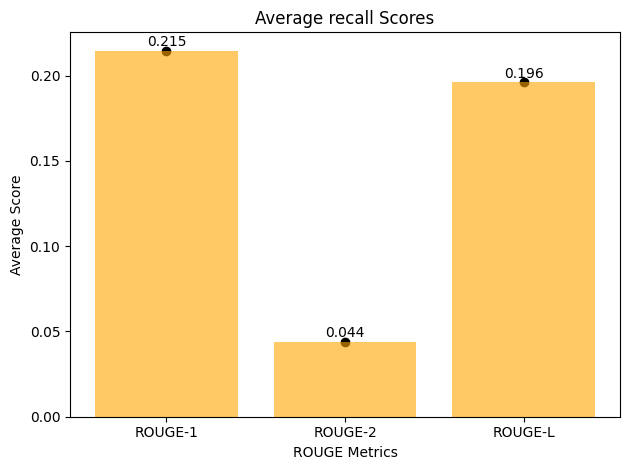

In [19]:
x_values = average_scores.columns
y_values = average_scores.loc['recall']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average recall Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

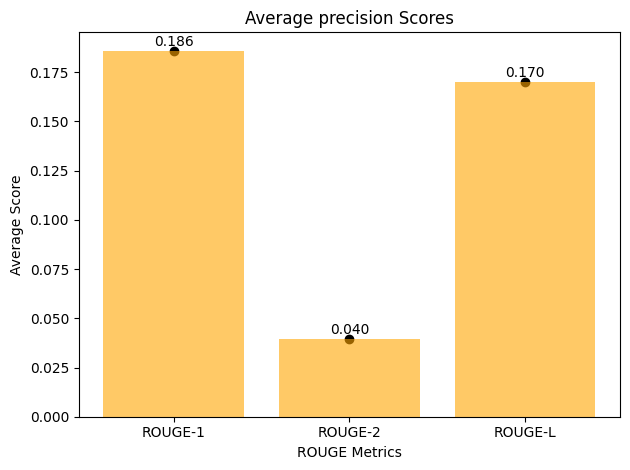

In [20]:
x_values = average_scores.columns
y_values = average_scores.loc['precision']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average precision Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

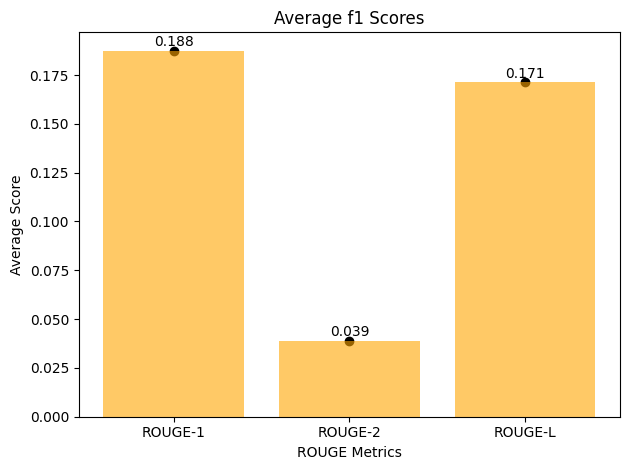

In [21]:
x_values = average_scores.columns
y_values = average_scores.loc['f1-score']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average f1 Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

#### Plot Heatmap for ROGUE scores

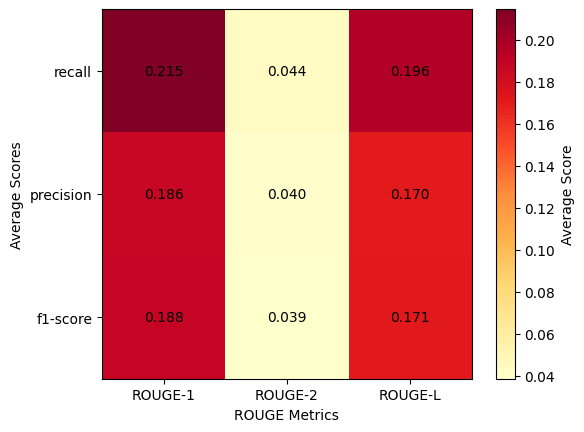

In [22]:
plt.imshow(average_scores, cmap='YlOrRd')

plt.xticks(range(len(average_scores.columns)), average_scores.columns)
plt.yticks(range(len(average_scores.index)), average_scores.index)
plt.xlabel('ROUGE Metrics')
plt.ylabel('Average Scores')

for i in range(len(average_scores.index)):
    for j in range(len(average_scores.columns)):
        plt.text(j, i, f'{average_scores.iloc[i, j]:.3f}', ha='center', va='center', color='black')

plt.colorbar(label='Average Score')

plt.show()